In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision
    ! pip install --upgrade git+https://github.com/sovrasov/flops-counter.pytorch.git

try:
    import torchtext
except:
    !pip install torchtext
    
try:
    import spacy
except:
    !pip install spacy
    
try:
    spacy.load('en')
except:
    !python -m spacy download en

# Data loading and preprocessing

In [0]:
import torch
from torchtext import data
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.distributions import Categorical
from torchtext import datasets

import random
import numpy as np
import os.path

In [0]:
TEXT = data.Field(tokenize='spacy', lower=True, include_lengths=True)
LABEL = data.LabelField(dtype=torch.float)
_train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [4]:
train_data, valid_data = _train_data.split(0.8)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 20000
Number of validation examples: 5000
Number of testing examples: 25000


In [5]:
TEXT.build_vocab(train_data, max_size=100000, vectors="glove.6B.100d")
LABEL.build_vocab(train_data)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 91454
Unique tokens in LABEL vocabulary: 2


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


# Model and training

In [0]:
BATCH_SIZE = 50

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device,
    shuffle = False,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True)

In [0]:
def reward_function(prob, true_label):
    """
    Returns 1 if correct prediction, -1 otherwise
    """
    # print("true_label", "prob", true_label, prob)
    if prob>0.5 and true_label>0.5:
        return torch.tensor(1.0, requires_grad=True)
    if prob<0.5 and true_label<0.5:
        return torch.tensor(1.0, requires_grad=True)
    return torch.tensor(-1.0, requires_grad=True)

class SimpleModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, gamma=0.99, train_mode=True):
        super().__init__()
        
        # store dimensions and constants
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.train_mode = True
        
        # create layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm_cell = nn.LSTMCell(input_size = embedding_dim, hidden_size = hidden_dim, bias = True)
        self.output_linear = nn.Linear(hidden_dim, output_dim)

        # Initialize lstm_cell states
        self.initialize_lstm_cell_states()
        
        # Initalize episode number and time number
        self.initialize_for_new_batch()
        self.initialize_time_number()
        
        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []
        self.training_accuracies = []
        self.validation_accuracies = []
        
        # torch.tensor((0.0), requires_grad=True) 
    
    def initialize_lstm_cell_states(self):
        self.c = torch.zeros(1, self.hidden_dim, requires_grad=True)
        self.h = torch.zeros(1, self.hidden_dim, requires_grad=True)
        
    def initialize_episode_number(self):
        self.ep = 0
    
    def initialize_time_number(self):
        self.t = 0
    
    def clear_batch_lists(self):
        del self.label_targets[:]
        del self.label_predictions[:]
        self.initialize_episode_number()
        self.training_accuracy = 0.0
    
    def initialize_for_new_batch(self):
        """
        Cleans history of log probabilities, rewards, targets etc for the last
        batch
        """
        self.initialize_episode_number()
        
        # Episode policy and reward history 

        # Predictions and targets history (for cross entropy loss calculation)
        self.label_predictions = [] # 1 probability for each episode
        self.label_targets = []# 1 label for each episode
        self.training_accuracy = 0.0

        
    def classify(self):
        out = self.output_linear(self.c[0])
        self.label_predictions.append(out)
        # return torch.sigmoid(out)
    
    def save_training_accuracy(self):
        correct = 0
        for (t, p) in zip(self.label_targets, self.label_predictions):
            if reward_function(p, t) > 0:
                correct += 1
        self.training_accuracy = correct/len(self.label_targets)
        self.training_accuracies.append(self.training_accuracy)
      
    
    def forward(self, pack):
        texts, lengths, labels = pack
        embeddeds = self.embedding(texts)
        # embeddeds = nn.utils.rnn.pack_padded_sequence(embeddeds, lengths)
        self.initialize_for_new_batch()

        for episode_number in range(embeddeds.shape[1]):
            
            # load episode data
            self.ep = episode_number
            embedded = embeddeds[:, self.ep, :]
      
            #print(texts.shape, embeddeds.shape, embedded.shape)
            #print(label)
            
            # initialize counters and index
            tokens_read = 0
            word_index = 0
            words_len = embedded.shape[0]
            self.initialize_lstm_cell_states()
            self.initialize_time_number()
            
            if self.train_mode:
                label = labels[self.ep].reshape(1)
                self.label_targets.append(label)
            
                # start iterating through sequence, while skipping some words
                while word_index<words_len:
                    self.t += 1
                    embedded_word = embedded[word_index]

                     # generate next lstm cell state
                    self.h, self.c = self.lstm_cell(torch.reshape(embedded_word, (1, -1)), (self.h, self.c))
                    word_index += 1
                    # print('word_index', word_index, 'tokens_read', tokens_read, 'jumps_made', jumps_made)
              
                    # if time to jump words
                self.classify()
        if self.train_mode:
            self.save_training_accuracy()
        return self.label_predictions 
      

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1

seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

bce = nn.BCEWithLogitsLoss(reduction='mean')
simple_model = SimpleModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
pretrained_embeddings = TEXT.vocab.vectors
simple_model.embedding.weight.data.copy_(pretrained_embeddings)

if os.path.exists('simple_model.weights'):
    simple_model.load_state_dict(torch.load('simple_model.weights'))

# define the optimiser
optimizer = optim.Adam(simple_model.parameters(), lr=0.01)

In [0]:
def update_policy():
   
    #print(len(policy_model.rewards), len(policy_model.label_predictions), len(policy_model.label_targets))
    #print(len(policy_model.saved_log_probs), len(policy_model.reward_baselines))
    
    J1 = bce(
        torch.cat(simple_model.label_predictions),
        torch.cat(simple_model.label_targets)
    )
    
    optimizer.zero_grad()
    # print('policy_loss', policy_loss)
    J1.backward(retain_graph=True)
    optimizer.step()
    
    simple_model.clear_batch_lists()

In [0]:
def test_model():
    simple_model.train_mode = True
    correct = 0
    total=0
    for _data in test_iterator:
        # get the inputs
        texts, text_lengths, labels = _data.text[0], _data.text[1], _data.label
        # print("Input review texts, text_lengths, labels", texts.shape, text_lengths.shape, labels.shape)
        predictions = simple_model((texts.to(device), text_lengths.to(device), labels.to(device)))
        for (prediction, label) in zip(predictions, labels):
            if reward_function(label, prediction) > 0:
                correct += 1
            total += 1
        if total%1000 == 0:
            print(total)
        if total%5000 == 0:
            break
    print("Test accuracy :", correct/total)
    simple_model.train_mode = True
    return correct/total

def validate_model():
    simple_model.train_mode = True
    correct = 0
    total=0
    for _data in valid_iterator:
        # get the inputs
        texts, text_lengths, labels = _data.text[0], _data.text[1], _data.label
        # print("Input review texts, text_lengths, labels", texts.shape, text_lengths.shape, labels.shape)
        predictions = simple_model((texts.to(device), text_lengths.to(device), labels.to(device)))
        for (prediction, label) in zip(predictions, labels):
            if reward_function(label, prediction) > 0:
                correct += 1
            total += 1
        if total%1000 == 0:
            break
    print("Validation accuracy :", correct/total)
    simple_model.validation_accuracies.append(correct/total)
    simple_model.train_mode = True
    return correct/total

# test_model()

In [33]:
# the epoch loop

with torch.enable_grad():
    validate_model()
    for epoch in range(5):
        running_reward = 10
        t = 0
        for _data in train_iterator:
            # get the inputs
            texts, text_lengths, labels = _data.text[0], _data.text[1], _data.label
            # print("Input review texts, text_lengths, labels", texts.shape, text_lengths.shape, labels.shape)
            prediction = simple_model((texts.to(device), text_lengths.to(device), labels.to(device)))
            # print("Prediction", prediction.item())        
            # raise ValueError('Not done')
            t += 1
            if t%2 == 0:
                print("batch no. %d, training accuracy %4.2f" % (t, simple_model.training_accuracy))
            if t%10 == 0:
                validate_model()
            if t%1000 == 0:
                break
            update_policy()
        print("Epoch %d" % (epoch))
    print('**** Finished Training ****')
# test_model()

Validation accuracy : 0.449
batch no. 2, training accuracy 0.54
batch no. 4, training accuracy 0.36
batch no. 6, training accuracy 0.40
batch no. 8, training accuracy 0.36
batch no. 10, training accuracy 0.46
Validation accuracy : 0.45
batch no. 12, training accuracy 0.58
batch no. 14, training accuracy 0.48
batch no. 16, training accuracy 0.44
batch no. 18, training accuracy 0.56
batch no. 20, training accuracy 0.50
Validation accuracy : 0.449
batch no. 22, training accuracy 0.56
batch no. 24, training accuracy 0.58
batch no. 26, training accuracy 0.54
batch no. 28, training accuracy 0.50
batch no. 30, training accuracy 0.48
Validation accuracy : 0.449
batch no. 32, training accuracy 0.74
batch no. 34, training accuracy 0.50
batch no. 36, training accuracy 0.38
batch no. 38, training accuracy 0.44
batch no. 40, training accuracy 0.52
Validation accuracy : 0.449
batch no. 42, training accuracy 0.50
batch no. 44, training accuracy 0.54
batch no. 46, training accuracy 0.56
batch no. 48, 

KeyboardInterrupt: ignored

In [0]:
torch.save(simple_model.state_dict(), 'simple_model.weights')

# Evaluation

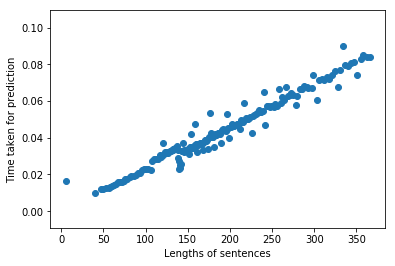

In [38]:
import timeit
import spacy
import matplotlib.pyplot as plt
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.train_mode = False
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    # tensor = torch.LongTensor(indexed).to(device)
    tensor = torch.LongTensor(indexed).to('cpu')
    tensor = tensor.unsqueeze(1)
    model((tensor, torch.tensor([tensor.shape[0]]), None))
    res = torch.sigmoid(model.label_predictions[0])
    model.train_mode = False
    return res

times = []
lengths=[]
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=1,
    device=device,
    shuffle = True,
    # sort_key=lambda x: len(x.text),
    sort_within_batch=False)

i = 0
for _data in test_iterator:
    if i%100 == 0:
        # get the inputs
        texts, text_lengths, labels = _data.text[0], _data.text[1], _data.label
        # print(texts.shape, text_lengths.shape, labels.shape)
        start_time = timeit.default_timer()
        predictions = simple_model((texts.to(device), text_lengths.to(device), labels.to(device)))
        elapsed = timeit.default_timer() - start_time
        lengths.append(texts.shape[0])
        times.append(elapsed)
        # print("Input review texts, text_lengths, labels", texts.shape, text_lengths.shape, labels.shape)
    if i>20000:
        break
    i += 1

import pickle

pickle_out = open("test_times_2.pickle","wb")
pickle.dump((lengths, times), pickle_out)
pickle_out.close()


plt.scatter(lengths, times)
plt.xlabel('Lengths of review')
plt.ylabel('Time taken for prediction')
plt.show()

In [0]:
predict_sentiment(simple_model, "This film is terrible what can I say")

In [0]:
import pickle

pickle_out = open("training_epochs_2.pickle","wb")
pickle.dump((simple_model.training_accuracies, simple_model.validation_accuracies), pickle_out)
pickle_out.close()